Loading of dataset

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayupermhm","key":"eb23365daeb6e97d59dc8f9cae743609"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'masoudnickparvar/brain-tumor-mri-dataset' --unzip --force

 94% 139M/149M [00:01<00:00, 127MB/s] 
100% 149M/149M [00:01<00:00, 102MB/s]


Import Necessary Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

Importing Data

In [ ]:
img_height, img_width = 299, 299
input_shape=torch.Tensor((img_height, img_width))
train_data_dir = '/content/Training'
validation_data_dir = '/content/Testing'

classes = ('glioma','meningioma','notumour','pituitary')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
# Resize the image and do a center crop, and store them on a tensor
transform = transforms.Compose([transforms.Resize(img_height),transforms.CenterCrop(img_width), transforms.ToTensor()])

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_data_dir, transform=transform)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)
channum =3

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


This is a glioma.


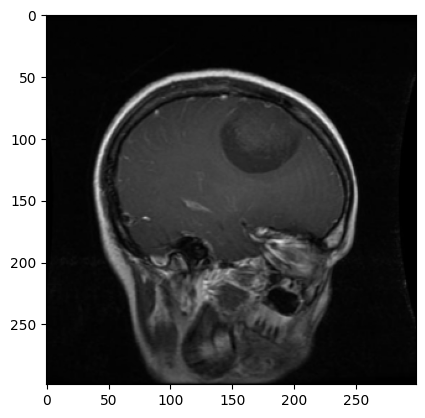

In [ ]:
images,labels = next(iter(train_loader))
print('This is a {}.'.format(classes[labels[0]]))
plt.imshow(images[0].moveaxis(0,2))

 pituitary     glioma   notumour meningioma


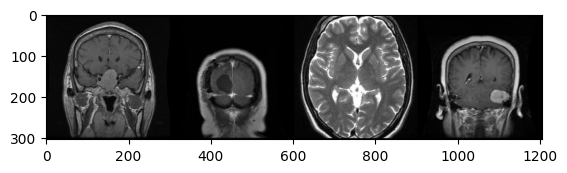

In [ ]:
number_of_pics = 4
images,labels = next(iter(train_loader)) #load in a batch of data with the dataloader
imagegrid = torchvision.utils.make_grid(images[0:number_of_pics,:,:,:]) #join the images from the batch into one grid
print(' '.join('%10s' % classes[labels[j]] for j in range(number_of_pics)))
plt.imshow(imagegrid.moveaxis(0,2))
plt.show()

In [ ]:
def calcsize(model, channum, imh, imw):
    image = torch.rand(channum, imh, imw)
    image = image[None, :]
    output = model(image)
    return output.shape[1:]

In [ ]:
def train_model(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    return train_loss, train_accuracy

def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = correct / total
    return test_loss, test_accuracy

In [ ]:
def grid_search(train_loader, val_loader, channum, img_height, img_width, device):
    results = []
    optimizers = ['Adam']
    learning_rates = [0.001, 0.0001, 0.00001]  # Define learning rates to test
    weight_decays = [0.0, 0.001, 0.01]  # Define weight decays to test
    num_epochs = 20  # Number of epochs to train

    for optimizer_name in optimizers:
        for lr in learning_rates:
            for wd in weight_decays:
                model = nn.Sequential(
                    nn.Conv2d(3, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 64, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)
                )

                output_size = calcsize(model, channum, img_height, img_width)

                layers = list(model.children())
                layers.extend([
                    nn.Flatten(),
                    nn.Linear(output_size[0] * output_size[1] * output_size[2], 64),
                    nn.Dropout(0.5),
                    nn.Linear(64, 4),
                    nn.Softmax(dim=1)
                ])

                model = nn.Sequential(*layers).to(device)

                if optimizer_name == 'Adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                criterion = nn.CrossEntropyLoss()

                print(f"Optimizer: {optimizer_name}, Learning Rate: {lr}, Weight Decay: {wd}")
                print(f"Epochs: {num_epochs}")
                for epoch in range(num_epochs):
                    print(f"Epoch {epoch + 1}/{num_epochs}")
                    train_loss, train_accuracy = train_model(model, optimizer, criterion, train_loader, device)
                    val_loss, val_accuracy = evaluate_model(model, criterion, val_loader, device)

                    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

                    results.append({
                        'optimizer': optimizer_name,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'epoch': epoch,
                        'train_loss': train_loss,
                        'train_accuracy': train_accuracy,
                        'val_loss': val_loss,
                        'val_accuracy': val_accuracy
                    })

    return results


In [ ]:
results = grid_search(train_loader, val_loader, channum, img_height, img_width, device)

Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0
Epochs: 20
Epoch 1/20
Train Loss: 1.0873, Train Accuracy: 0.6513, Val Loss: 1.0866, Val Accuracy: 0.6537
Epoch 2/20
Train Loss: 1.0445, Train Accuracy: 0.6968, Val Loss: 1.2430, Val Accuracy: 0.5011
Epoch 3/20
Train Loss: 1.0504, Train Accuracy: 0.6900, Val Loss: 1.1324, Val Accuracy: 0.6110
Epoch 4/20
Train Loss: 1.0230, Train Accuracy: 0.7197, Val Loss: 1.0112, Val Accuracy: 0.7330
Epoch 5/20
Train Loss: 0.9715, Train Accuracy: 0.7714, Val Loss: 1.0189, Val Accuracy: 0.7239
Epoch 6/20
Train Loss: 0.9637, Train Accuracy: 0.7791, Val Loss: 1.0176, Val Accuracy: 0.7262
Epoch 7/20
Train Loss: 0.9840, Train Accuracy: 0.7593, Val Loss: 1.0197, Val Accuracy: 0.7231
Epoch 8/20
Train Loss: 0.9744, Train Accuracy: 0.7684, Val Loss: 1.0034, Val Accuracy: 0.7399
Epoch 9/20
Train Loss: 0.9541, Train Accuracy: 0.7890, Val Loss: 1.0442, Val Accuracy: 0.6987
Epoch 10/20
Train Loss: 1.0077, Train Accuracy: 0.7355, Val Loss: 1.1097, Val Accuracy

In [ ]:
for result in results:
    print(f"Optimizer: {result['optimizer']}, Learning Rate: {result['learning_rate']}, Weight Decay: {result['weight_decay']}, Epoch: {result['epoch']}")
    print(f"Train Accuracy: {result['train_accuracy']}, Test Accuracy: {result['val_accuracy']}")

Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 0
Train Accuracy: 0.6512605042016807, Test Accuracy: 0.6536994660564455
Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 1
Train Accuracy: 0.6967787114845938, Test Accuracy: 0.5011441647597255
Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 2
Train Accuracy: 0.6899509803921569, Test Accuracy: 0.6109839816933639
Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 3
Train Accuracy: 0.7197128851540616, Test Accuracy: 0.7330282227307399
Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 4
Train Accuracy: 0.771358543417367, Test Accuracy: 0.7238749046529367
Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 5
Train Accuracy: 0.77906162464986, Test Accuracy: 0.7261632341723875
Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.0, Epoch: 6
Train Accuracy: 0.7592787114845938, Test Accuracy: 0.7231121281464531
Optimizer: Adam, Learning Rate: 0.001, Weigh

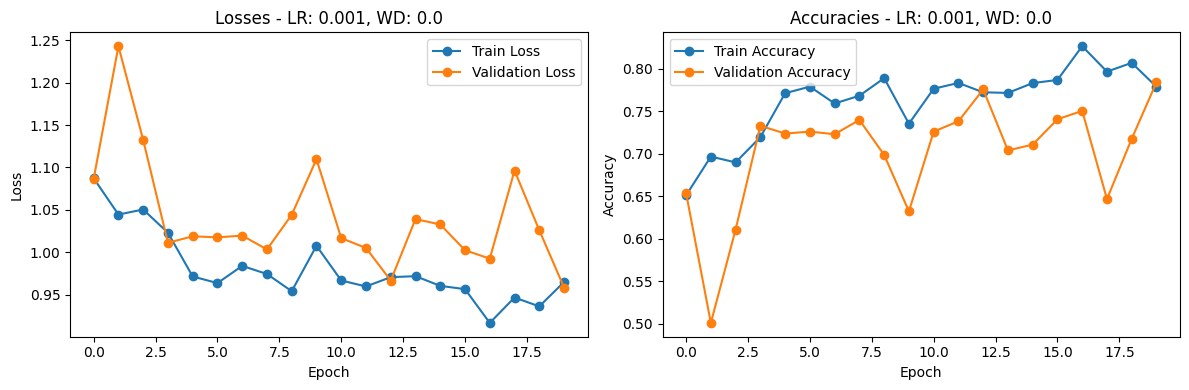

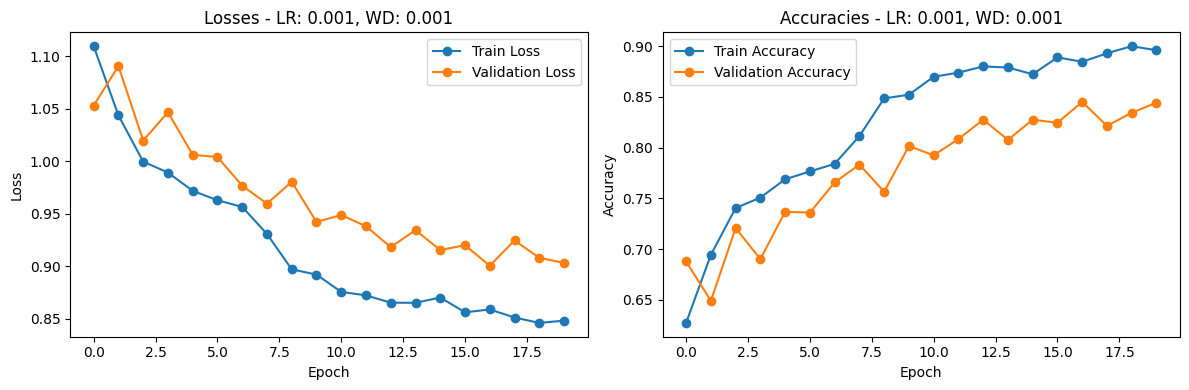

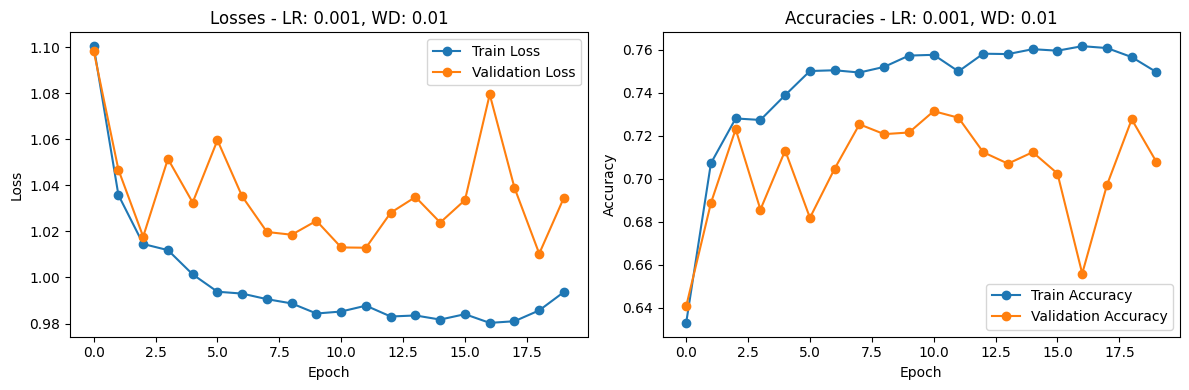

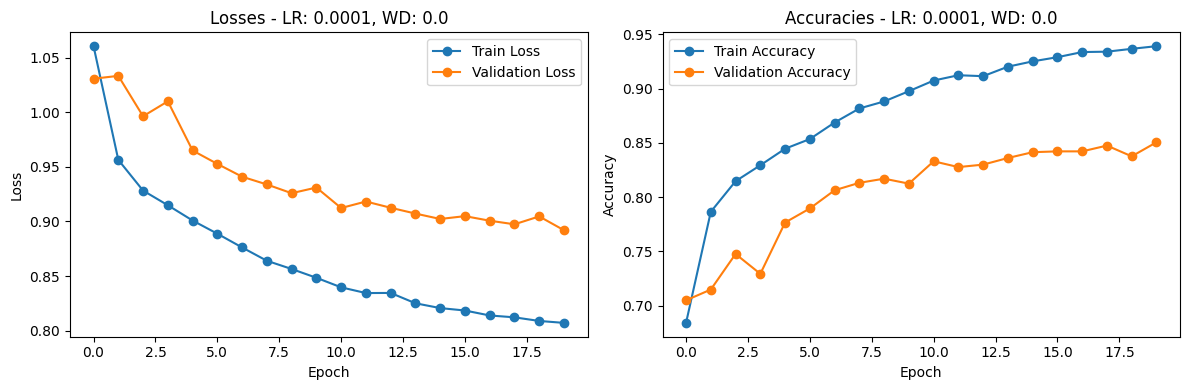

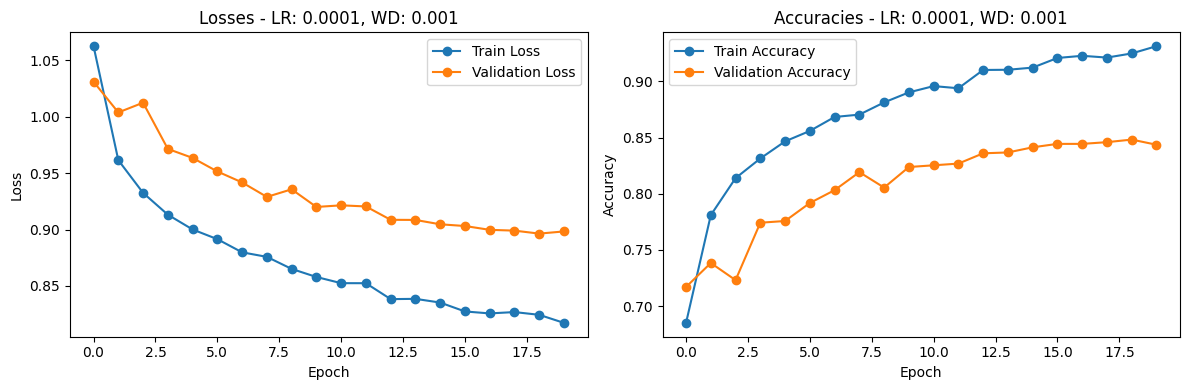

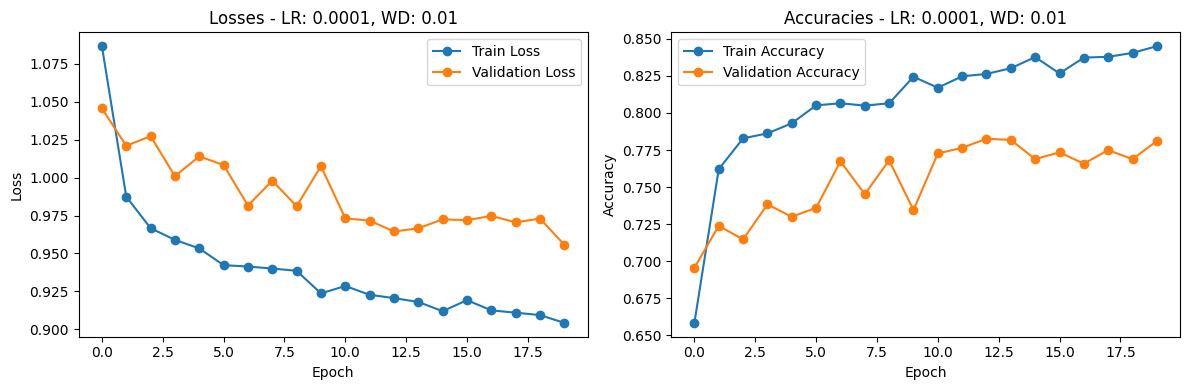

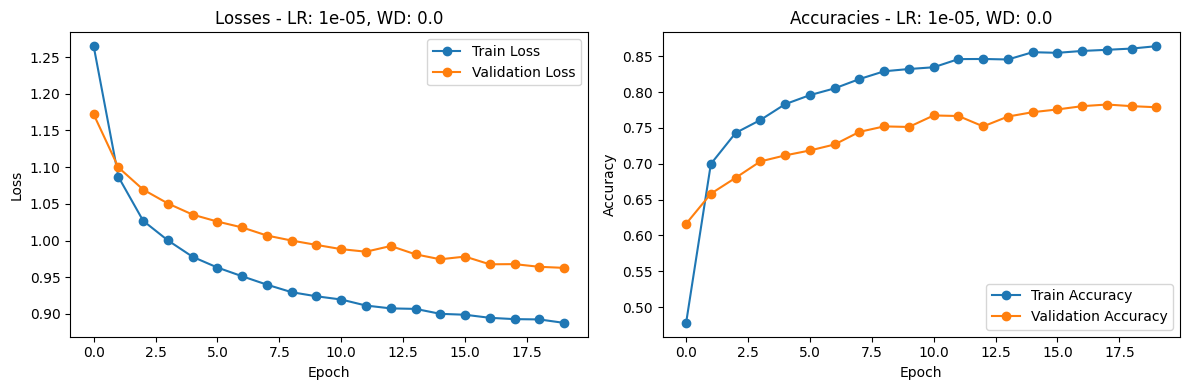

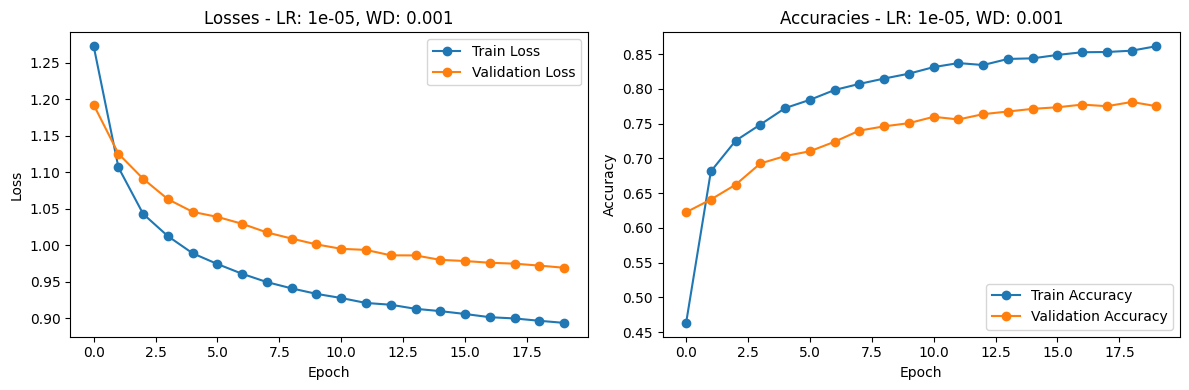

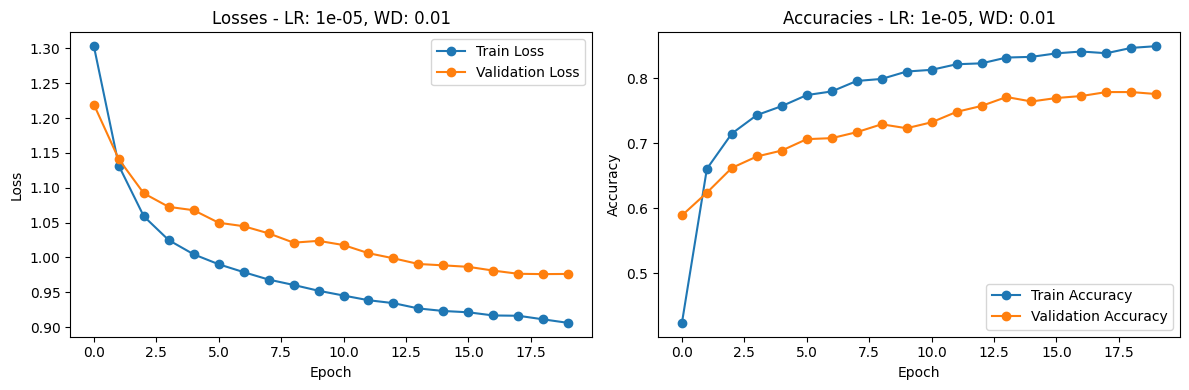

In [ ]:
import numpy as np
# Separate results by learning rate and weight decay
lr_wd_results = {}
for result in results:
    lr = result['learning_rate']
    wd = result['weight_decay']
    key = (lr, wd)
    if key not in lr_wd_results:
        lr_wd_results[key] = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    lr_wd_results[key]['epoch'].append(result['epoch'])
    lr_wd_results[key]['train_loss'].append(result['train_loss'])
    lr_wd_results[key]['val_loss'].append(result['val_loss'])
    lr_wd_results[key]['train_accuracy'].append(result['train_accuracy'])
    lr_wd_results[key]['val_accuracy'].append(result['val_accuracy'])

# Plot loss and accuracy for each LR and WD combination
for key, result in lr_wd_results.items():
    lr, wd = key
    epoch = np.array(result['epoch']).flatten()  # Flatten the epoch list
    train_loss = result['train_loss']
    train_accuracy = result['train_accuracy']
    val_loss = result['val_loss']
    val_accuracy = result['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epoch, train_loss, label='Train Loss', marker='o')
    plt.plot(epoch, val_loss, label='Validation Loss', marker='o')
    plt.title(f'Losses - LR: {lr}, WD: {wd}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epoch, train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(epoch, val_accuracy, label='Validation Accuracy', marker='o')
    plt.title(f'Accuracies - LR: {lr}, WD: {wd}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
lr_wd_results = {}
for result in results:
    lr = result['learning_rate']
    wd = result['weight_decay']
    key = (lr, wd)
    if key not in lr_wd_results:
        lr_wd_results[key] = {'val_accuracy': []}

    lr_wd_results[key]['val_accuracy'].append(result['val_accuracy'])

# Find the best combination based on the highest validation accuracy
best_lr_wd = None
best_val_accuracy = -1
for key, result in lr_wd_results.items():
    val_accuracy_avg = np.mean(result['val_accuracy'])
    if val_accuracy_avg > best_val_accuracy:
        best_val_accuracy = val_accuracy_avg
        best_lr_wd = key

best_lr, best_wd = best_lr_wd
print(f"Best combination - LR: {best_lr}, WD: {best_wd}, Validation Accuracy: {best_val_accuracy:.4f}")

Best combination - LR: 0.0001, WD: 0.001, Validation Accuracy: 0.8082


Training using Best Combination

In [ ]:
def grid_search(train_loader, val_loader, channum, img_height, img_width, device):
    results = []
    optimizers = ['Adam']
    learning_rates = [0.0001]  # Define a single learning rate to test
    weight_decays = [0.001]    # Define a single weight decay to test
    num_epochs = 20  # Number of epochs to train

    for optimizer_name in optimizers:
        for lr in learning_rates:
            for wd in weight_decays:
                model = nn.Sequential(
                    nn.Conv2d(3, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 64, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)
                )

                output_size = calcsize(model, channum, img_height, img_width)

                layers = list(model.children())
                layers.extend([
                    nn.Flatten(),
                    nn.Linear(output_size[0] * output_size[1] * output_size[2], 64),
                    nn.Dropout(0.5),
                    nn.Linear(64, 4),
                    nn.Softmax(dim=1)
                ])

                model = nn.Sequential(*layers).to(device)

                if optimizer_name == 'Adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                criterion = nn.CrossEntropyLoss()

                print(f"Optimizer: {optimizer_name}, Learning Rate: {lr}, Weight Decay: {wd}")
                print(f"Epochs: {num_epochs}")
                for epoch in range(num_epochs):
                    print(f"Epoch {epoch + 1}/{num_epochs}")
                    train_loss, train_accuracy = train_model(model, optimizer, criterion, train_loader, device)
                    val_loss, val_accuracy = evaluate_model(model, criterion, val_loader, device)

                    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

                    results.append({
                        'optimizer': optimizer_name,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'epoch': epoch,
                        'train_loss': train_loss,
                        'train_accuracy': train_accuracy,
                        'val_loss': val_loss,
                        'val_accuracy': val_accuracy
                    })

    return results


In [ ]:
results = grid_search(train_loader, val_loader, channum, img_height, img_width, device)

Optimizer: Adam, Learning Rate: 0.0001, Weight Decay: 0.001
Epochs: 20
Epoch 1/20


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 1.0777, Train Accuracy: 0.6689, Val Loss: 1.0348, Val Accuracy: 0.7048
Epoch 2/20
Train Loss: 0.9680, Train Accuracy: 0.7756, Val Loss: 1.0043, Val Accuracy: 0.7376
Epoch 3/20
Train Loss: 0.9289, Train Accuracy: 0.8174, Val Loss: 1.0030, Val Accuracy: 0.7399
Epoch 4/20
Train Loss: 0.9126, Train Accuracy: 0.8351, Val Loss: 0.9972, Val Accuracy: 0.7460
Epoch 5/20
Train Loss: 0.9043, Train Accuracy: 0.8412, Val Loss: 0.9519, Val Accuracy: 0.7895
Epoch 6/20
Train Loss: 0.8897, Train Accuracy: 0.8564, Val Loss: 0.9535, Val Accuracy: 0.7872
Epoch 7/20
Train Loss: 0.8862, Train Accuracy: 0.8605, Val Loss: 0.9535, Val Accuracy: 0.7918
Epoch 8/20
Train Loss: 0.8738, Train Accuracy: 0.8718, Val Loss: 0.9378, Val Accuracy: 0.8108
Epoch 9/20
Train Loss: 0.8649, Train Accuracy: 0.8825, Val Loss: 0.9285, Val Accuracy: 0.8192
Epoch 10/20
Train Loss: 0.8574, Train Accuracy: 0.8908, Val Loss: 0.9122, Val Accuracy: 0.8330
Epoch 11/20
Train Loss: 0.8526, Train Accuracy: 0.8964, Val Loss: 0.91

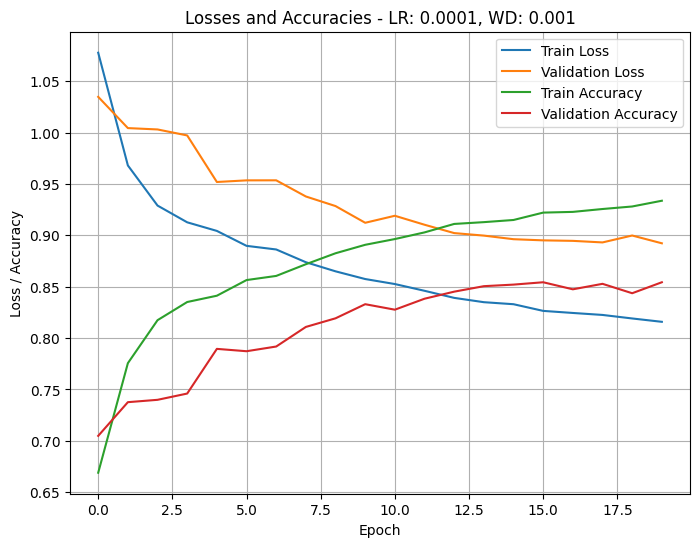

In [ ]:
# Separate results by learning rate and weight decay
lr_wd_results = {}
for result in results:
    lr = result['learning_rate']
    wd = result['weight_decay']
    key = (lr, wd)
    if key not in lr_wd_results:
        lr_wd_results[key] = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    lr_wd_results[key]['epoch'].append(result['epoch'])
    lr_wd_results[key]['train_loss'].append(result['train_loss'])
    lr_wd_results[key]['val_loss'].append(result['val_loss'])
    lr_wd_results[key]['train_accuracy'].append(result['train_accuracy'])
    lr_wd_results[key]['val_accuracy'].append(result['val_accuracy'])

# Plot loss and accuracy for each LR and WD combination
for key, result in lr_wd_results.items():
    lr, wd = key
    epoch = np.array(result['epoch']).flatten()  # Flatten the epoch list
    train_loss = result['train_loss']
    train_accuracy = result['train_accuracy']
    val_loss = result['val_loss']
    val_accuracy = result['val_accuracy']

    # Plot loss and accuracy together
    plt.figure(figsize=(8, 6))
    plt.plot(epoch, train_loss, label='Train Loss' )
    plt.plot(epoch, val_loss, label='Validation Loss')
    plt.plot(epoch, train_accuracy, label='Train Accuracy')
    plt.plot(epoch, val_accuracy, label='Validation Accuracy')
    plt.title(f'Losses and Accuracies - LR: {lr}, WD: {wd}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


Data Augmentation

In [ ]:
# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(img_height, img_width), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define test transform
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
def grid_search(train_loader, val_loader, channum, img_height, img_width, device):
    results = []
    optimizers = ['Adam']
    learning_rates = [0.0001]  # Define learning rates to test
    weight_decays = [0.001]  # Define weight decays to test
    num_epochs = 20  # Number of epochs to train

    for optimizer_name in optimizers:
        for lr in learning_rates:
            for wd in weight_decays:

                # Create train and validation loaders
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

                model = nn.Sequential(
                    nn.Conv2d(3, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(32, 64, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)
                )

                output_size = calcsize(model, channum, img_height, img_width)

                layers = list(model.children())
                layers.extend([
                    nn.Flatten(),
                    nn.Linear(output_size[0] * output_size[1] * output_size[2], 64),
                    nn.Dropout(0.5),
                    nn.Linear(64, 4),
                    nn.Softmax(dim=1)
                ])

                model = nn.Sequential(*layers).to(device)

                if optimizer_name == 'Adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                criterion = nn.CrossEntropyLoss()

                print(f"Optimizer: {optimizer_name}, Learning Rate: {lr}, Weight Decay: {wd}")
                print(f"Epochs: {num_epochs}")
                for epoch in range(num_epochs):
                    print(f"Epoch {epoch + 1}/{num_epochs}")
                    train_loss, train_accuracy = train_model(model, optimizer, criterion, train_loader, device)
                    val_loss, val_accuracy = evaluate_model(model, criterion, val_loader, device)

                    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

                    results.append({
                        'optimizer': optimizer_name,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'epoch': epoch,
                        'train_loss': train_loss,
                        'train_accuracy': train_accuracy,
                        'val_loss': val_loss,
                        'val_accuracy': val_accuracy
                    })

    return results


In [ ]:
results = grid_search(train_loader, val_loader, channum, img_height, img_width, device)

Optimizer: Adam, Learning Rate: 0.0001, Weight Decay: 0.001
Epochs: 20
Epoch 1/20
Train Loss: 1.0737, Train Accuracy: 0.6698, Val Loss: 1.0401, Val Accuracy: 0.6941
Epoch 2/20
Train Loss: 0.9535, Train Accuracy: 0.7927, Val Loss: 0.9924, Val Accuracy: 0.7551
Epoch 3/20
Train Loss: 0.9277, Train Accuracy: 0.8176, Val Loss: 0.9696, Val Accuracy: 0.7735
Epoch 4/20
Train Loss: 0.9113, Train Accuracy: 0.8370, Val Loss: 0.9609, Val Accuracy: 0.7872
Epoch 5/20
Train Loss: 0.8947, Train Accuracy: 0.8529, Val Loss: 0.9621, Val Accuracy: 0.7765
Epoch 6/20
Train Loss: 0.8909, Train Accuracy: 0.8533, Val Loss: 0.9422, Val Accuracy: 0.8047
Epoch 7/20
Train Loss: 0.8765, Train Accuracy: 0.8720, Val Loss: 0.9441, Val Accuracy: 0.8002
Epoch 8/20
Train Loss: 0.8716, Train Accuracy: 0.8757, Val Loss: 0.9460, Val Accuracy: 0.7979
Epoch 9/20


KeyboardInterrupt: 

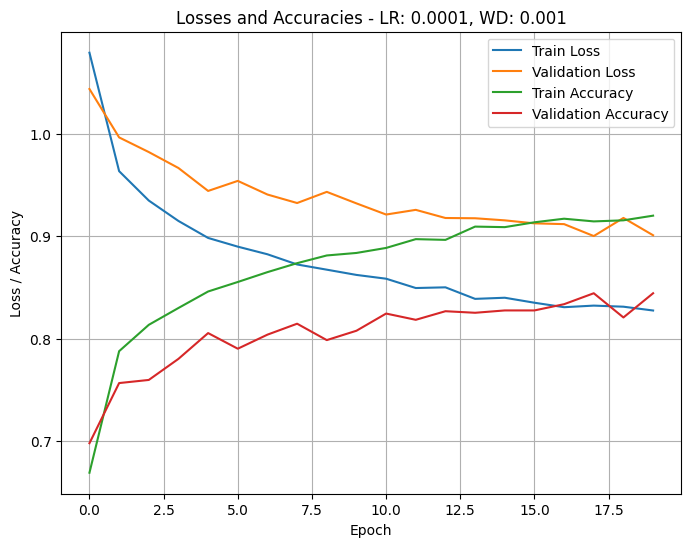

In [ ]:
# Separate results by learning rate and weight decay
lr_wd_results = {}
for result in results:
    lr = result['learning_rate']
    wd = result['weight_decay']
    key = (lr, wd)
    if key not in lr_wd_results:
        lr_wd_results[key] = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    lr_wd_results[key]['epoch'].append(result['epoch'])
    lr_wd_results[key]['train_loss'].append(result['train_loss'])
    lr_wd_results[key]['val_loss'].append(result['val_loss'])
    lr_wd_results[key]['train_accuracy'].append(result['train_accuracy'])
    lr_wd_results[key]['val_accuracy'].append(result['val_accuracy'])

# Plot loss and accuracy for each LR and WD combination
for key, result in lr_wd_results.items():
    lr, wd = key
    epoch = np.array(result['epoch']).flatten()  # Flatten the epoch list
    train_loss = result['train_loss']
    train_accuracy = result['train_accuracy']
    val_loss = result['val_loss']
    val_accuracy = result['val_accuracy']

    # Plot loss and accuracy together
    plt.figure(figsize=(8, 6))
    plt.plot(epoch, train_loss, label='Train Loss' )
    plt.plot(epoch, val_loss, label='Validation Loss')
    plt.plot(epoch, train_accuracy, label='Train Accuracy')
    plt.plot(epoch, val_accuracy, label='Validation Accuracy')
    plt.title(f'Losses and Accuracies - LR: {lr}, WD: {wd}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(img_height, img_width), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
results = grid_search(train_loader, val_loader, channum, img_height, img_width, device)

Optimizer: Adam, Learning Rate: 0.0001, Weight Decay: 0.001
Epochs: 20
Epoch 1/20
Train Loss: 1.0853, Train Accuracy: 0.6598, Val Loss: 1.0452, Val Accuracy: 0.7018
Epoch 2/20
Train Loss: 0.9592, Train Accuracy: 0.7868, Val Loss: 0.9970, Val Accuracy: 0.7452
Epoch 3/20
Train Loss: 0.9308, Train Accuracy: 0.8144, Val Loss: 0.9706, Val Accuracy: 0.7696
Epoch 4/20
Train Loss: 0.9082, Train Accuracy: 0.8388, Val Loss: 0.9800, Val Accuracy: 0.7605
Epoch 5/20
Train Loss: 0.8980, Train Accuracy: 0.8494, Val Loss: 0.9620, Val Accuracy: 0.7872
Epoch 6/20
Train Loss: 0.8852, Train Accuracy: 0.8592, Val Loss: 0.9453, Val Accuracy: 0.8032
Epoch 7/20
Train Loss: 0.8812, Train Accuracy: 0.8659, Val Loss: 0.9338, Val Accuracy: 0.8093
Epoch 8/20
Train Loss: 0.8736, Train Accuracy: 0.8738, Val Loss: 0.9253, Val Accuracy: 0.8223
Epoch 9/20
Train Loss: 0.8623, Train Accuracy: 0.8853, Val Loss: 0.9287, Val Accuracy: 0.8116
Epoch 10/20
Train Loss: 0.8602, Train Accuracy: 0.8874, Val Loss: 0.9156, Val Accur

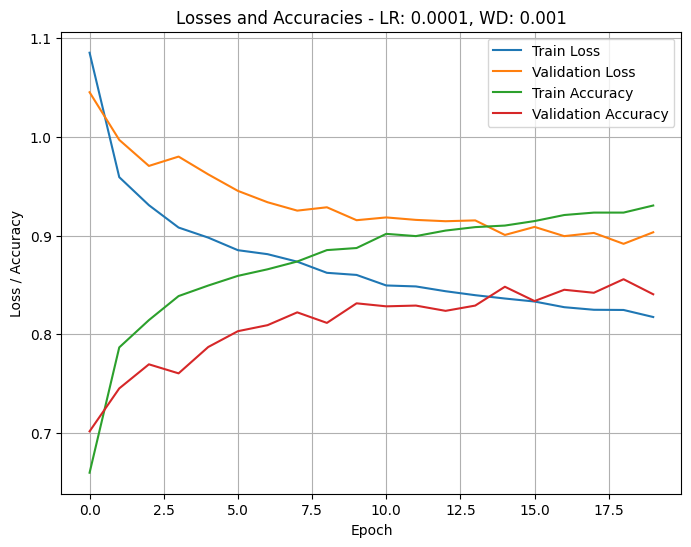

In [ ]:
# Separate results by learning rate and weight decay
lr_wd_results = {}
for result in results:
    lr = result['learning_rate']
    wd = result['weight_decay']
    key = (lr, wd)
    if key not in lr_wd_results:
        lr_wd_results[key] = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    lr_wd_results[key]['epoch'].append(result['epoch'])
    lr_wd_results[key]['train_loss'].append(result['train_loss'])
    lr_wd_results[key]['val_loss'].append(result['val_loss'])
    lr_wd_results[key]['train_accuracy'].append(result['train_accuracy'])
    lr_wd_results[key]['val_accuracy'].append(result['val_accuracy'])

# Plot loss and accuracy for each LR and WD combination
for key, result in lr_wd_results.items():
    lr, wd = key
    epoch = np.array(result['epoch']).flatten()  # Flatten the epoch list
    train_loss = result['train_loss']
    train_accuracy = result['train_accuracy']
    val_loss = result['val_loss']
    val_accuracy = result['val_accuracy']

    # Plot loss and accuracy together
    plt.figure(figsize=(8, 6))
    plt.plot(epoch, train_loss, label='Train Loss' )
    plt.plot(epoch, val_loss, label='Validation Loss')
    plt.plot(epoch, train_accuracy, label='Train Accuracy')
    plt.plot(epoch, val_accuracy, label='Validation Accuracy')
    plt.title(f'Losses and Accuracies - LR: {lr}, WD: {wd}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


L2 Regularization

In [ ]:
def train_model(model, optimizer, criterion, train_loader, device, l2_reg_strength=0.001):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate L2 regularization term
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)

        loss += l2_reg_strength * l2_reg  # Add L2 regularization term to the loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    return train_loss, train_accuracy


In [ ]:
def grid_search(train_loader, val_loader, channum, img_height, img_width, device):
    results = []
    optimizers = ['Adam']
    learning_rates = [0.0001]  # Define learning rates to test
    weight_decays = [0.001]  # Define weight decays to test
    l2_reg_strengths = [0.001]  # Define L2 regularization strengths to test
    num_epochs = 20  # Number of epochs to train

    for optimizer_name in optimizers:
        for lr in learning_rates:
            for wd in weight_decays:
                for l2_reg_strength in l2_reg_strengths:
                    # Create train and validation loaders
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

                    model = nn.Sequential(
                        nn.Conv2d(3, 32, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 32, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 64, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2)
                    )

                    output_size = calcsize(model, channum, img_height, img_width)

                    layers = list(model.children())
                    layers.extend([
                        nn.Flatten(),
                        nn.Linear(output_size[0] * output_size[1] * output_size[2], 64),
                        nn.Dropout(0.5),
                        nn.Linear(64, 4),
                        nn.Softmax(dim=1)
                    ])

                    model = nn.Sequential(*layers).to(device)

                    if optimizer_name == 'Adam':
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                    criterion = nn.CrossEntropyLoss()

                    print(f"Optimizer: {optimizer_name}, Learning Rate: {lr}, Weight Decay: {wd}, L2 Regularization Strength: {l2_reg_strength}")
                    print(f"Epochs: {num_epochs}")
                    for epoch in range(num_epochs):
                        print(f"Epoch {epoch + 1}/{num_epochs}")
                        train_loss, train_accuracy = train_model(model, optimizer, criterion, train_loader, device, l2_reg_strength=l2_reg_strength)
                        val_loss, val_accuracy = evaluate_model(model, criterion, val_loader, device)

                        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

                        results.append({
                            'optimizer': optimizer_name,
                            'learning_rate': lr,
                            'weight_decay': wd,
                            'l2_reg_strength': l2_reg_strength,
                            'epoch': epoch,
                            'train_loss': train_loss,
                            'train_accuracy': train_accuracy,
                            'val_loss': val_loss,
                            'val_accuracy': val_accuracy
                        })

    return results


In [ ]:
results = grid_search(train_loader, val_loader, channum, img_height, img_width, device)

Optimizer: Adam, Learning Rate: 0.0001, Weight Decay: 0.001, L2 Regularization Strength: 0.001
Epochs: 20
Epoch 1/20
Train Loss: 1.0863, Train Accuracy: 0.6817, Val Loss: 1.0374, Val Accuracy: 0.7056
Epoch 2/20
Train Loss: 0.9726, Train Accuracy: 0.7901, Val Loss: 1.0656, Val Accuracy: 0.6659
Epoch 3/20
Train Loss: 0.9545, Train Accuracy: 0.8088, Val Loss: 0.9916, Val Accuracy: 0.7590
Epoch 4/20
Train Loss: 0.9355, Train Accuracy: 0.8304, Val Loss: 0.9952, Val Accuracy: 0.7529
Epoch 5/20
Train Loss: 0.9203, Train Accuracy: 0.8468, Val Loss: 0.9889, Val Accuracy: 0.7574
Epoch 6/20
Train Loss: 0.9138, Train Accuracy: 0.8545, Val Loss: 0.9610, Val Accuracy: 0.7826
Epoch 7/20
Train Loss: 0.9070, Train Accuracy: 0.8589, Val Loss: 0.9453, Val Accuracy: 0.8002
Epoch 8/20
Train Loss: 0.8984, Train Accuracy: 0.8687, Val Loss: 0.9503, Val Accuracy: 0.7994
Epoch 9/20
Train Loss: 0.8922, Train Accuracy: 0.8759, Val Loss: 0.9324, Val Accuracy: 0.8124
Epoch 10/20
Train Loss: 0.8852, Train Accuracy: 

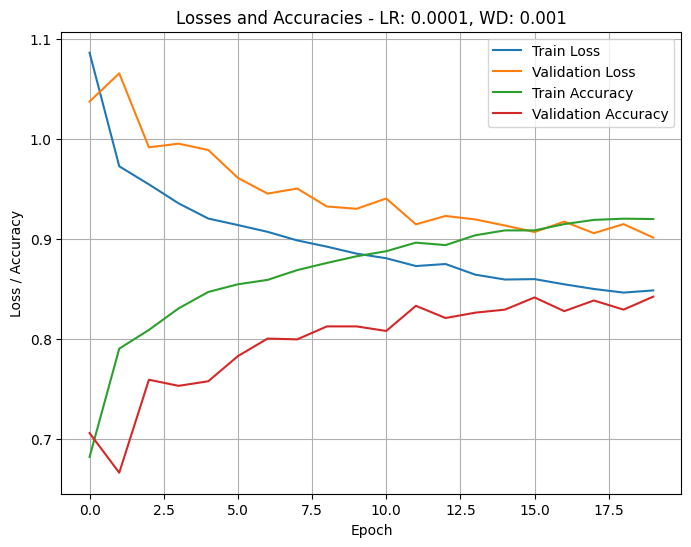

In [ ]:
# Separate results by learning rate and weight decay
lr_wd_results = {}
for result in results:
    lr = result['learning_rate']
    wd = result['weight_decay']
    key = (lr, wd)
    if key not in lr_wd_results:
        lr_wd_results[key] = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    lr_wd_results[key]['epoch'].append(result['epoch'])
    lr_wd_results[key]['train_loss'].append(result['train_loss'])
    lr_wd_results[key]['val_loss'].append(result['val_loss'])
    lr_wd_results[key]['train_accuracy'].append(result['train_accuracy'])
    lr_wd_results[key]['val_accuracy'].append(result['val_accuracy'])

# Plot loss and accuracy for each LR and WD combination
for key, result in lr_wd_results.items():
    lr, wd = key
    epoch = np.array(result['epoch']).flatten()  # Flatten the epoch list
    train_loss = result['train_loss']
    train_accuracy = result['train_accuracy']
    val_loss = result['val_loss']
    val_accuracy = result['val_accuracy']

    # Plot loss and accuracy together
    plt.figure(figsize=(8, 6))
    plt.plot(epoch, train_loss, label='Train Loss' )
    plt.plot(epoch, val_loss, label='Validation Loss')
    plt.plot(epoch, train_accuracy, label='Train Accuracy')
    plt.plot(epoch, val_accuracy, label='Validation Accuracy')
    plt.title(f'Losses and Accuracies - LR: {lr}, WD: {wd}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
